# Import library and Data Analysis






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization, Input
from keras.optimizers import Adam
from keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental import preprocessing
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import mixed_precision
mixed_precision.set_global_policy('float32')


print(tf.__version__)

2.15.0


Loading dataset

In [3]:
# Define dataset paths
dataset = {
            "train_data" : "/content/drive/MyDrive/Thesis /dataset_new/train",
             "valid_data" : "/content/drive/MyDrive/Thesis /dataset_new/valid",
             "test_data" : "/content/drive/MyDrive/Thesis /dataset_new/test"
}


all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()



train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

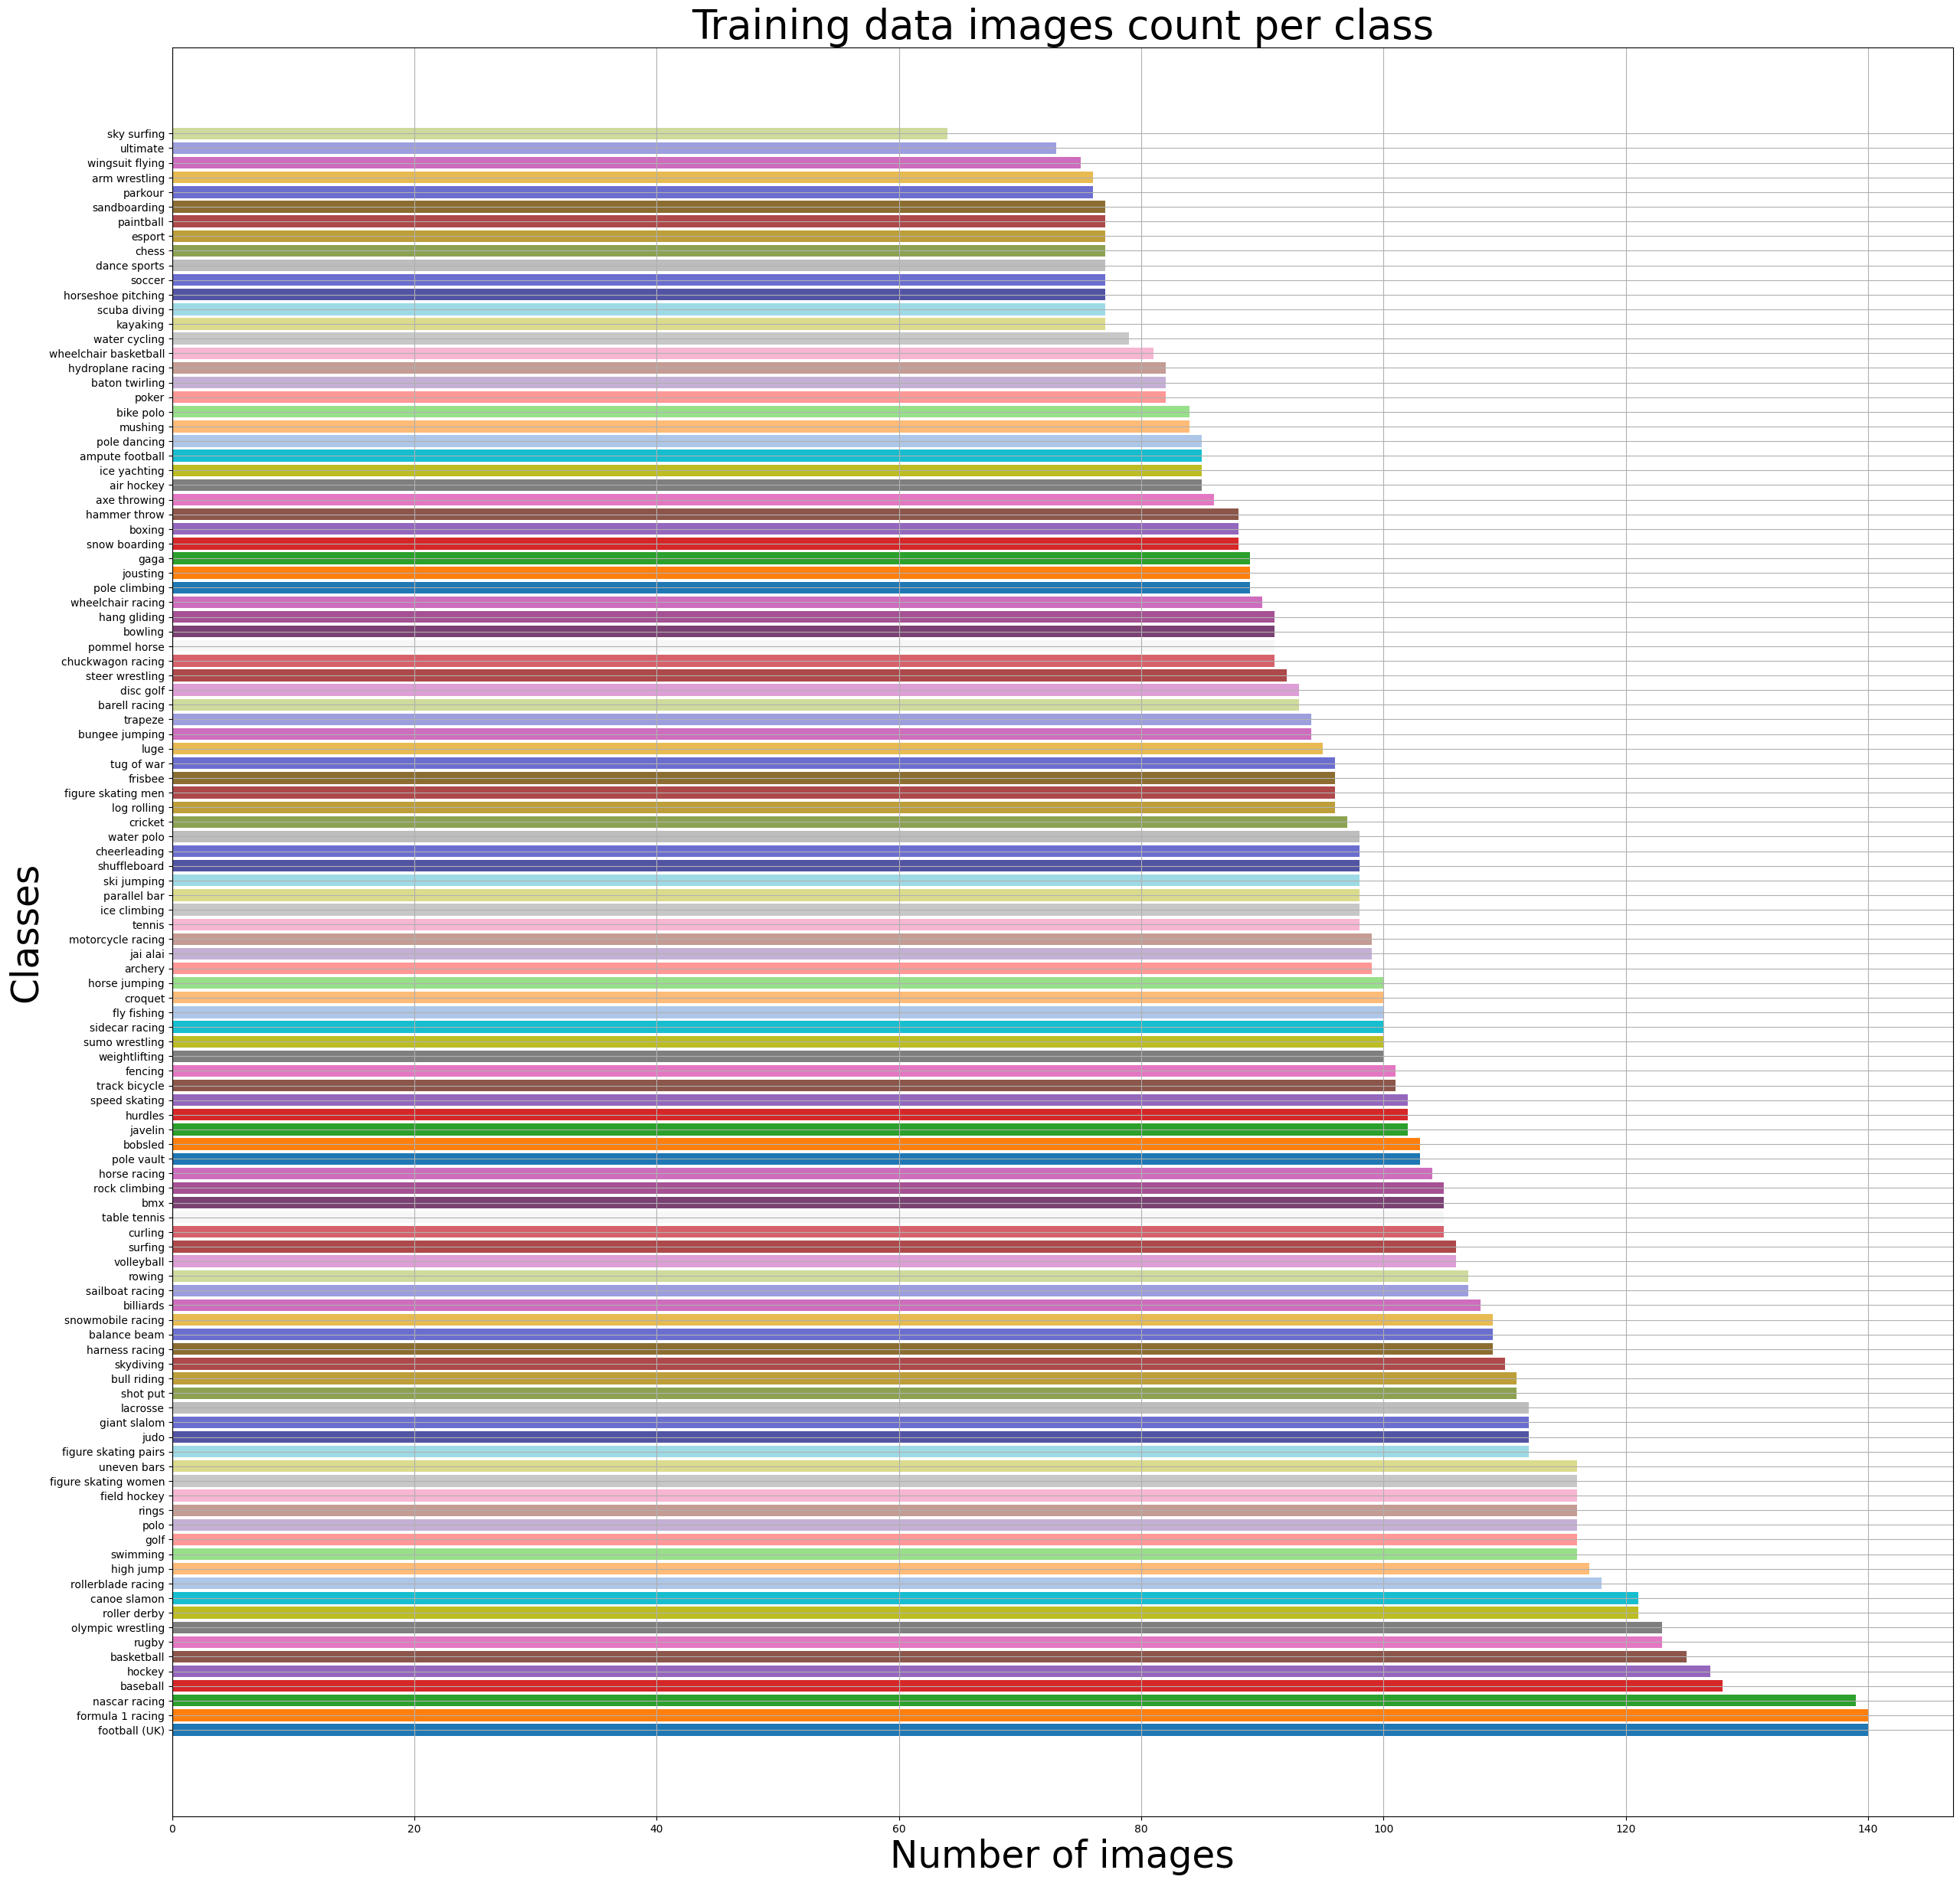

In [4]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()


In [5]:
train_df.sample(n=15, random_state=1)

imgpath  \
3991   /content/drive/MyDrive/Thesis /dataset_new/tra...   
6222   /content/drive/MyDrive/Thesis /dataset_new/tra...   
4663   /content/drive/MyDrive/Thesis /dataset_new/tra...   
1410   /content/drive/MyDrive/Thesis /dataset_new/tra...   
10668  /content/drive/MyDrive/Thesis /dataset_new/tra...   
3701   /content/drive/MyDrive/Thesis /dataset_new/tra...   
1433   /content/drive/MyDrive/Thesis /dataset_new/tra...   
7330   /content/drive/MyDrive/Thesis /dataset_new/tra...   
4906   /content/drive/MyDrive/Thesis /dataset_new/tra...   
6117   /content/drive/MyDrive/Thesis /dataset_new/tra...   
394    /content/drive/MyDrive/Thesis /dataset_new/tra...   
6058   /content/drive/MyDrive/Thesis /dataset_new/tra...   
4403   /content/drive/MyDrive/Thesis /dataset_new/tra...   
597    /content/drive/MyDrive/Thesis /dataset_new/tra...   
5281   /content/drive/MyDrive/Thesis /dataset_new/tra...   

                     labels  encoded_labels  
3991          pole climbing              68  
6222           giant slalom              38  
4663            log rolling              58  
1410               swimming              95  
10668         football (UK)              34  
3701             pole vault              70  
1433          speed skating              91  
7330   figure skating women              32  
4906           ice climbing              50  
6117           giant slalom              38  
394              water polo             105  
6058              high jump              43  
4403      olympic wrestling              63  
597              tug of war             100  
5281           ice yachting              51

In [6]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath         labels
0  /content/drive/MyDrive/Thesis /dataset_new/tra...  weightlifting
1  /content/drive/MyDrive/Thesis /dataset_new/tra...  weightlifting
2  /content/drive/MyDrive/Thesis /dataset_new/tra...  weightlifting
3  /content/drive/MyDrive/Thesis /dataset_new/tra...  weightlifting
4  /content/drive/MyDrive/Thesis /dataset_new/tra...  weightlifting
(10880, 3)
--------Validation----------
                                             imgpath      labels
0  /content/drive/MyDrive/Thesis /dataset_new/val...  tug of war
1  /content/drive/MyDrive/Thesis /dataset_new/val...  tug of war
2  /content/drive/MyDrive/Thesis /dataset_new/val...  tug of war
3  /content/drive/MyDrive/Thesis /dataset_new/val...  tug of war
4  /content/drive/MyDrive/Thesis /dataset_new/val...  tug of war
(2401, 3)
----------Test--------------
                                             imgpath           labels
0  /content/drive/MyDriv

Show sample from data

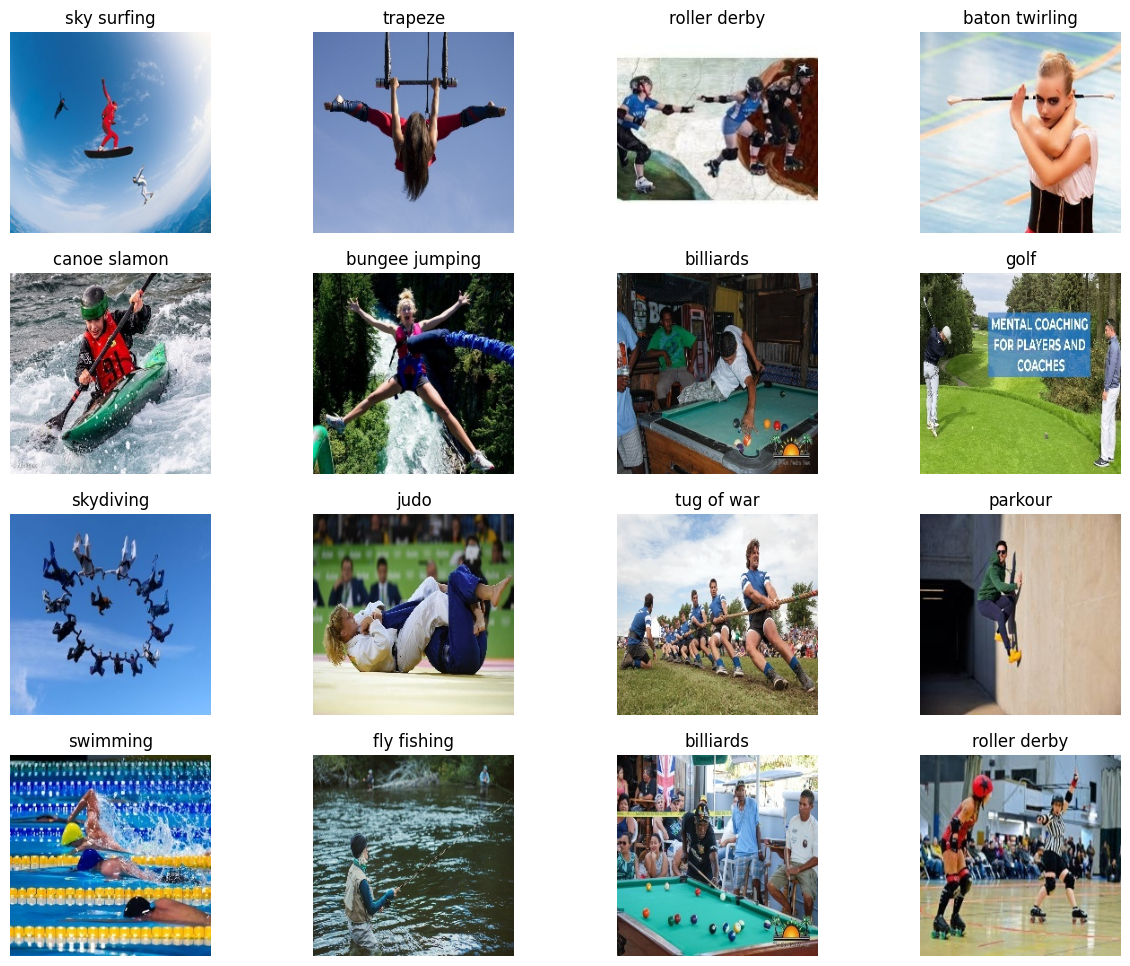

In [7]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

#EfficientNet B0

In [ ]:
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [ ]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(350)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 350)               448350    
                                                                 
 activation (Activation)     (None, 350)               0         
                                                                 
 batch_normalization (Batch  (None, 350)               1400  

Training: Transfer learning

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save('/content/drive/MyDrive/Thesis /dataset_new/EfficientNetB0.h5')

Epoch 1/50
1088/1088 [==============================] - 86s 67ms/step - loss: 2.1095 - accuracy: 0.5155 - val_loss: 0.7542 - val_accuracy: 0.8067 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 69s 63ms/step - loss: 0.9710 - accuracy: 0.7590 - val_loss: 0.6246 - val_accuracy: 0.8259 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 68s 63ms/step - loss: 0.7784 - accuracy: 0.8019 - val_loss: 0.5485 - val_accuracy: 0.8617 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 68s 62ms/step - loss: 0.6444 - accuracy: 0.8288 - val_loss: 0.4862 - val_accuracy: 0.8688 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 70s 64ms/step - loss: 0.5775 - accuracy: 0.8484 - val_loss: 0.4289 - val_accuracy: 0.8805 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 68s 62ms/step - loss: 0.5494 - accuracy: 0.8488 - val_loss: 0.5187 - val_accuracy: 0.8526 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

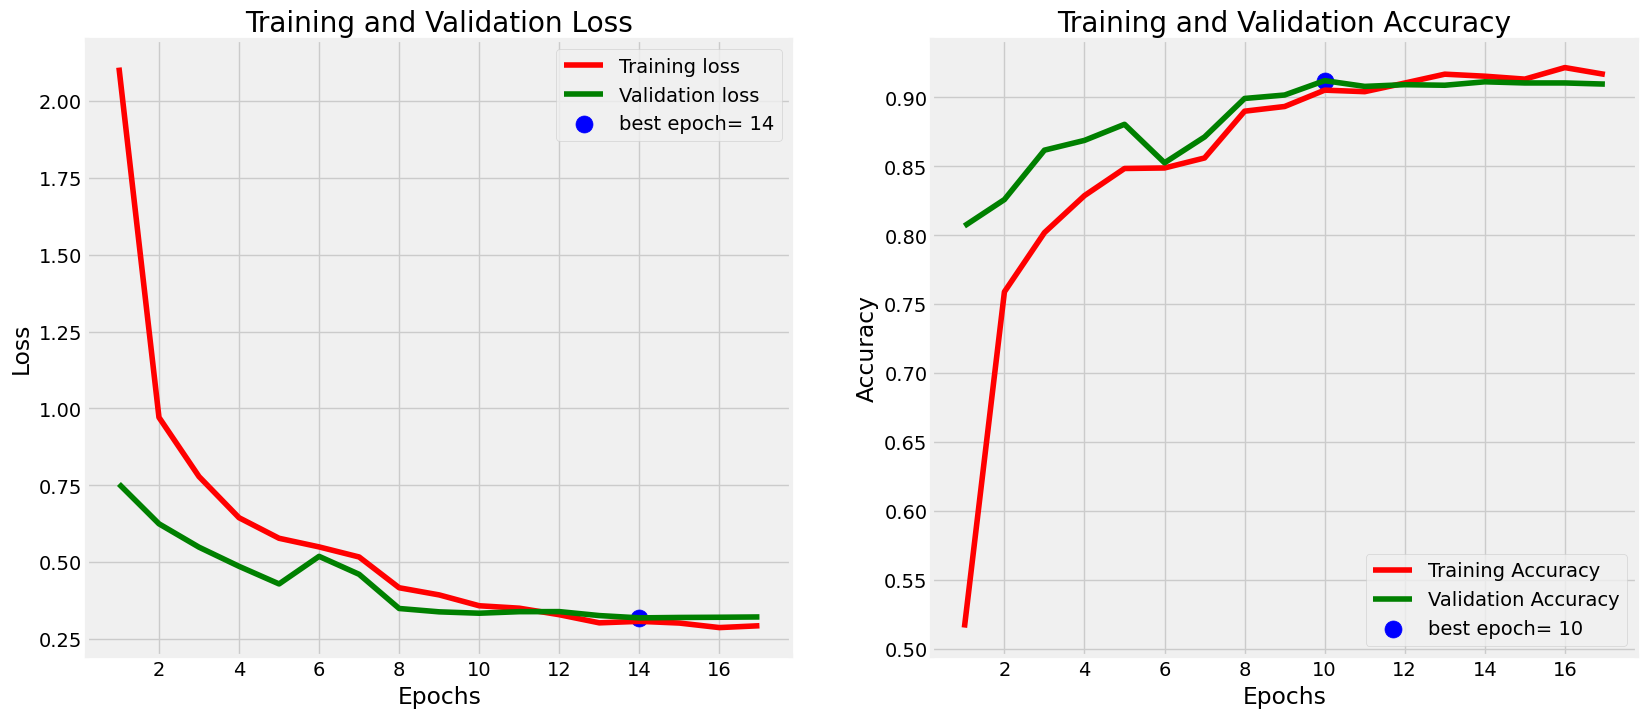

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


Model Evaluate

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.26596
Test Accuracy: 92.03%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

234/234 [==============================] - 13s 50ms/step
F1 Score: 0.9199947692007818
                       precision    recall  f1-score   support

           air hockey       0.95      1.00      0.97        18
      ampute football       1.00      1.00      1.00        18
              archery       0.90      0.90      0.90        21
        arm wrestling       0.89      1.00      0.94        16
         axe throwing       0.94      0.89      0.91        18
         balance beam       0.86      1.00      0.92        24
        barell racing       0.91      1.00      0.95        20
             baseball       0.80      0.86      0.83        28
           basketball       0.77      0.85      0.81        27
       baton twirling       0.84      0.89      0.86        18
            bike polo       0.70      0.89      0.78        18
            billiards       1.00      1.00      1.00        23
                  bmx       1.00      0.55      0.71        22
              bobsled       0.9

#VGG16

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_vgg16 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_vgg16 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_vgg16 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [ ]:
from keras.applications import VGG16
# Load and modify the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
from keras.layers import GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast
num_classes = len(set(train_images_vgg16.classes))
# Define data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
  RandomZoom(0.1),
  RandomContrast(0.1),
], name='data_augmentation')

# Modify the model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Set training=False for batch norm layers
x = GlobalAveragePooling2D()(x)
x = Dense(350, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 350)               179550    
                                                                 
 batch_normalization_1 (Bat  (None, 350)               1400

Training: Transfer learning

In [ ]:
# Train the model
history_vgg16 = model.fit(
    train_images_vgg16,
    steps_per_epoch=len(train_images_vgg16),
    validation_data=val_images_vgg16,
    validation_steps=len(val_images_vgg16),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Thesis /dataset_new/VGG16.h5')

Epoch 1/50
1088/1088 [==============================] - 79s 70ms/step - loss: 3.1564 - accuracy: 0.2822 - val_loss: 2.1286 - val_accuracy: 0.5485 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 74s 68ms/step - loss: 1.9209 - accuracy: 0.5132 - val_loss: 1.5891 - val_accuracy: 0.6493 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 73s 67ms/step - loss: 1.5879 - accuracy: 0.5917 - val_loss: 1.4832 - val_accuracy: 0.6718 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 75s 69ms/step - loss: 1.4437 - accuracy: 0.6175 - val_loss: 1.4294 - val_accuracy: 0.6951 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 82s 75ms/step - loss: 1.3500 - accuracy: 0.6356 - val_loss: 1.4254 - val_accuracy: 0.7214 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 75s 69ms/step - loss: 1.2598 - accuracy: 0.6623 - val_loss: 1.6964 - val_accuracy: 0.7110 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

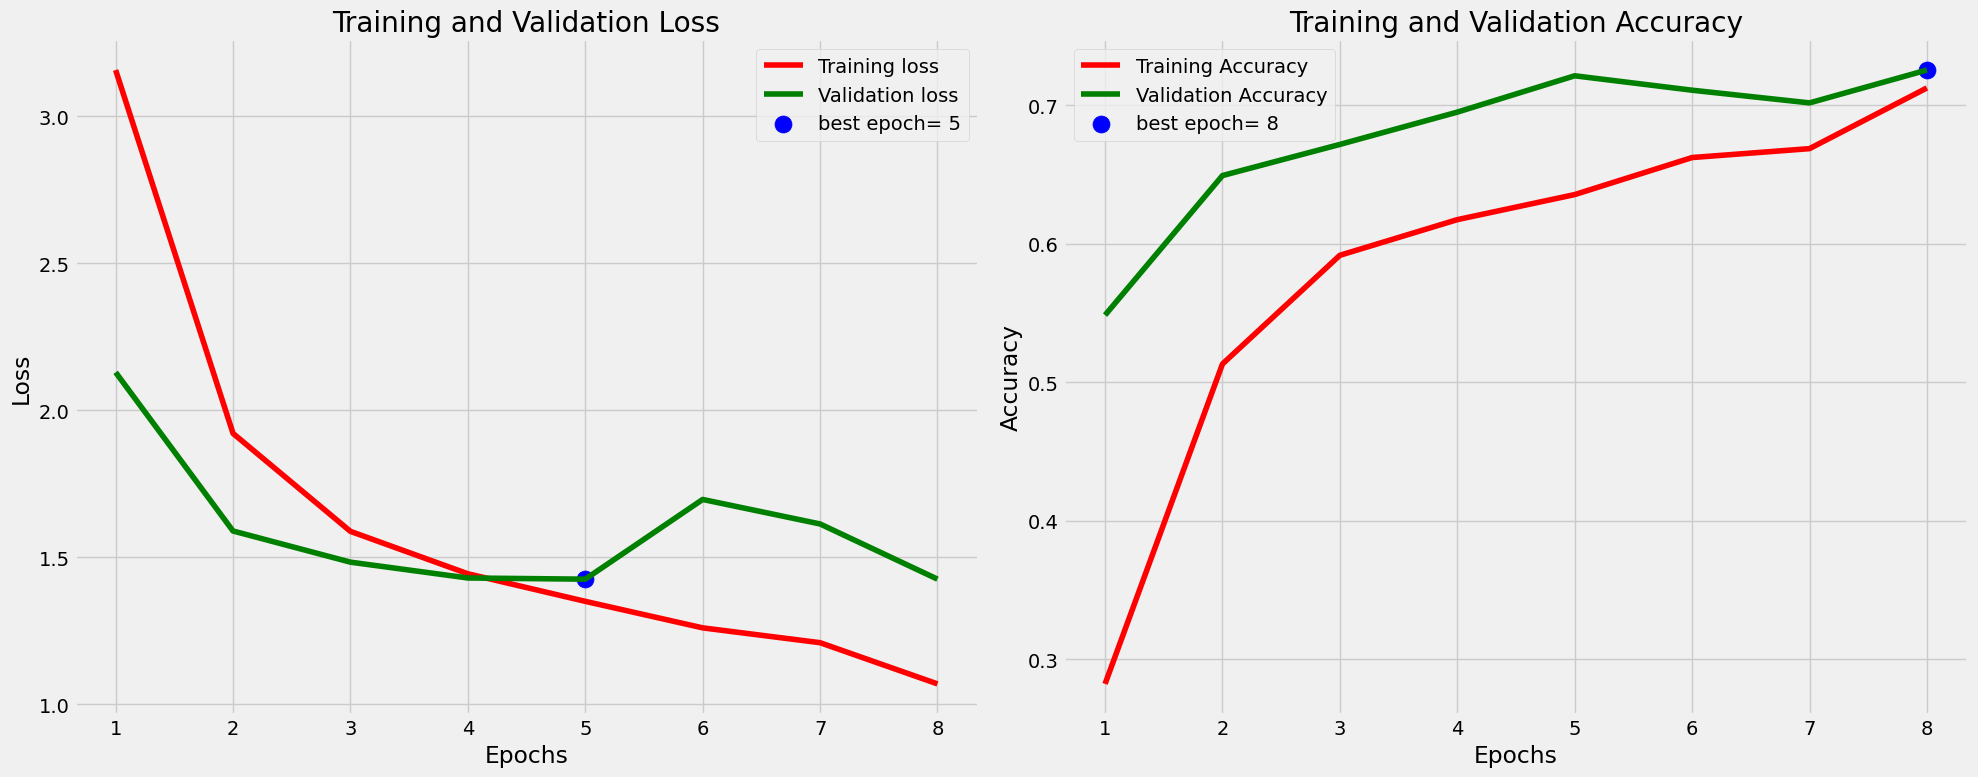

In [ ]:
# Corrected variable assignments
tr_acc = history_vgg16.history['accuracy']
tr_loss = history_vgg16.history['loss']
val_acc = history_vgg16.history['val_accuracy']
val_loss = history_vgg16.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model evaluate

In [ ]:
results = model.evaluate(test_images_vgg16, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.35404
Test Accuracy: 71.82%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_vgg16.classes
y_pred = np.argmax(model.predict(test_images_vgg16), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_vgg16.class_indices.keys()))

234/234 [==============================] - 13s 54ms/step
F1 Score: 0.7137468292120827
                       precision    recall  f1-score   support

           air hockey       0.87      0.72      0.79        18
      ampute football       0.75      0.83      0.79        18
              archery       0.75      0.71      0.73        21
        arm wrestling       0.78      0.88      0.82        16
         axe throwing       0.80      0.89      0.84        18
         balance beam       0.88      0.58      0.70        24
        barell racing       0.49      0.95      0.64        20
             baseball       0.46      0.57      0.51        28
           basketball       0.71      0.63      0.67        27
       baton twirling       0.83      0.83      0.83        18
            bike polo       0.52      0.83      0.64        18
            billiards       0.79      0.96      0.86        23
                  bmx       0.92      0.55      0.69        22
              bobsled       0.6

#ResNet50

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_resnet50 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_resnet50 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_resnet50 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [ ]:
from keras.applications import ResNet50
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

In [ ]:
num_classes = len(set(train_images_resnet50.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Load pre-trained ResNet50 model
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

inputs_resnet50 = layers.Input(shape=(224, 224, 3), name='inputLayer')
x_resnet50 = augment(inputs_resnet50)
pretrain_out_resnet50 = pretrained_model_resnet50(x_resnet50, training=False)
x_resnet50 = layers.Dense(350, activation="relu")(pretrain_out_resnet50)
x_resnet50 = layers.BatchNormalization()(x_resnet50)
x_resnet50 = layers.Dropout(0.25)(x_resnet50)
x_resnet50 = layers.Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_resnet50)

model_resnet50 = Model(inputs=inputs_resnet50, outputs=x_resnet50)

model_resnet50.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model_resnet50.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 350)               717150    
                                                                 
 batch_normalization (Batch  (None, 350)               1400      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 350)               0     

Transfer learning

In [ ]:
history_resnet50 = model_resnet50.fit(
    train_images_resnet50,
    steps_per_epoch=len(train_images_resnet50),
    validation_data=val_images_resnet50,
    validation_steps=len(val_images_resnet50),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_resnet50.save_weights('/content/drive/MyDrive/Thesis /dataset_new/ResNet50.h5')

Epoch 1/50
1088/1088 [==============================] - 86s 70ms/step - loss: 2.6866 - accuracy: 0.3883 - val_loss: 1.3256 - val_accuracy: 0.6489 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 75s 69ms/step - loss: 1.5039 - accuracy: 0.6286 - val_loss: 0.8802 - val_accuracy: 0.7480 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 74s 68ms/step - loss: 1.2136 - accuracy: 0.6908 - val_loss: 0.7846 - val_accuracy: 0.7813 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 76s 70ms/step - loss: 1.0849 - accuracy: 0.7187 - val_loss: 0.8113 - val_accuracy: 0.7638 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 84s 78ms/step - loss: 0.9838 - accuracy: 0.7321 - val_loss: 0.7560 - val_accuracy: 0.7730 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 83s 77ms/step - loss: 0.9323 - accuracy: 0.7466 - val_loss: 0.7505 - val_accuracy: 0.7930 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

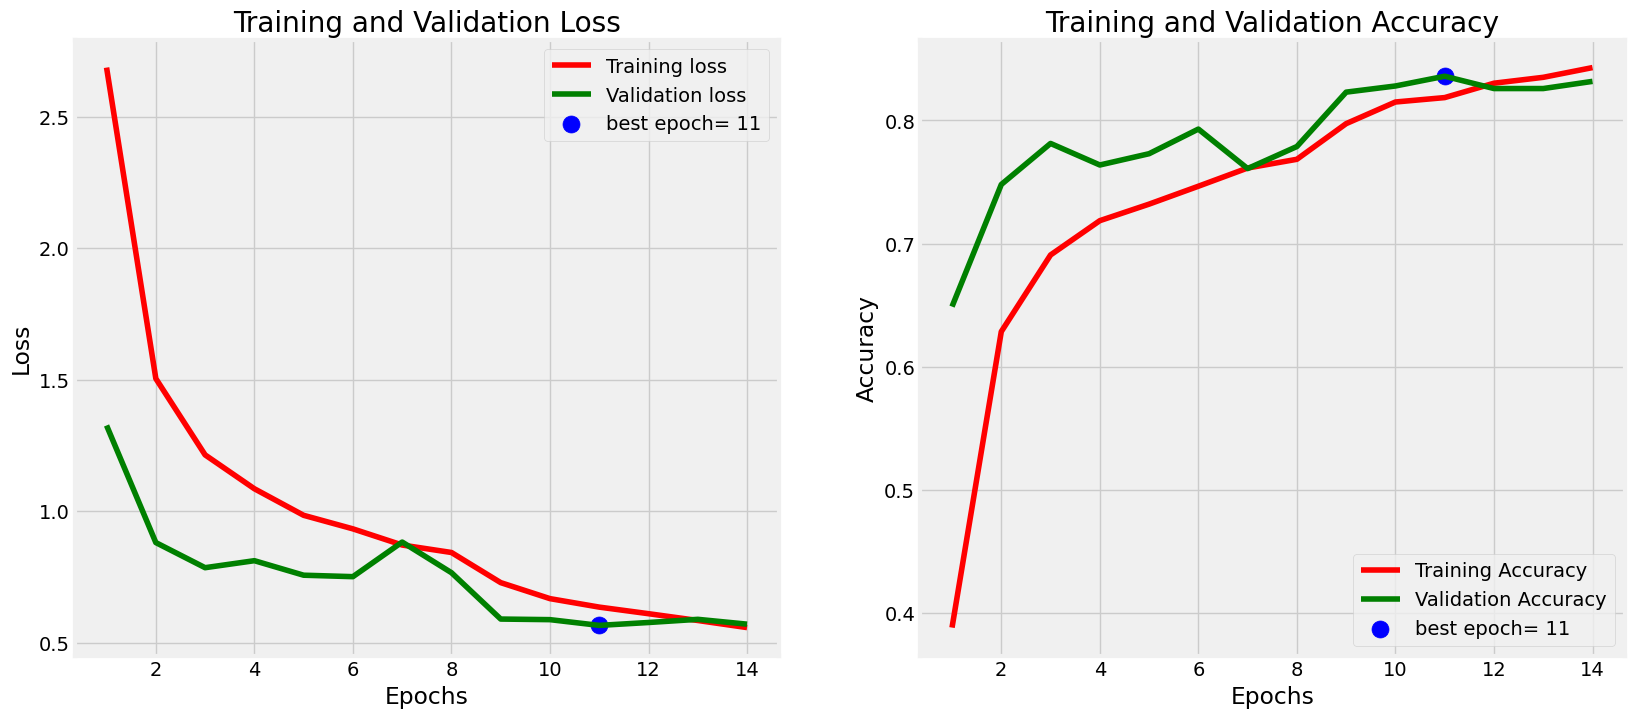

In [ ]:
# Define needed variables
tr_acc = history_resnet50.history['accuracy']
tr_loss = history_resnet50.history['loss']
val_acc = history_resnet50.history['val_accuracy']
val_loss = history_resnet50.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

  model evaluate

In [ ]:
results_resnet50 = model_resnet50.evaluate(test_images_resnet50, verbose=0)
print("ResNet50 Model - Test Loss: {:.5f}".format(results_resnet50[0]))
print("ResNet50 Model - Test Accuracy: {:.2f}%".format(results_resnet50[1] * 100))

ResNet50 Model - Test Loss: 0.60001
ResNet50 Model - Test Accuracy: 83.73%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_resnet50.classes
y_pred = np.argmax(model_resnet50.predict(test_images_resnet50), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_resnet50.class_indices.keys()))

234/234 [==============================] - 13s 53ms/step
F1 Score: 0.8357489066431701
                       precision    recall  f1-score   support

           air hockey       0.71      0.94      0.81        18
      ampute football       0.94      0.83      0.88        18
              archery       0.72      0.86      0.78        21
        arm wrestling       0.84      1.00      0.91        16
         axe throwing       0.77      0.94      0.85        18
         balance beam       0.88      0.88      0.88        24
        barell racing       0.90      0.95      0.93        20
             baseball       0.86      0.68      0.76        28
           basketball       0.79      0.70      0.75        27
       baton twirling       0.79      0.83      0.81        18
            bike polo       0.62      0.89      0.73        18
            billiards       0.88      1.00      0.94        23
                  bmx       0.78      0.32      0.45        22
              bobsled       0.6

#MobileNet V3 Large

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input)

BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_mobilenet = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_mobilenet = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_mobilenet = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [ ]:
from keras.applications import MobileNetV3Large

pretrained_model_mobilenetv3 = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_mobilenetv3.layers:
    layer.trainable = False

12683000/12683000 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import GlobalAveragePooling2D
num_classes = len(set(train_images_mobilenet.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Building the model
inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)
x = pretrained_model_mobilenetv3(x, training=False)
x = layers.Dense(350, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 350)               336350    
                                                                 
 batch_normalization_1 (Bat  (None, 350)               1400      
 chNormalization)                                                
                                                           

Transfer learning

In [ ]:
# Training the model
history = model.fit(
    train_images_mobilenet,
    steps_per_epoch=len(train_images_mobilenet),
    validation_data=val_images_mobilenet,
    validation_steps=len(val_images_mobilenet),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Thesis /dataset_new/MobileNetV3Large.h5')


Epoch 1/50
1088/1088 [==============================] - 72s 61ms/step - loss: 2.2716 - accuracy: 0.4715 - val_loss: 0.8623 - val_accuracy: 0.7851 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 64s 59ms/step - loss: 0.9978 - accuracy: 0.7439 - val_loss: 0.7482 - val_accuracy: 0.8113 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 64s 59ms/step - loss: 0.7547 - accuracy: 0.7980 - val_loss: 0.5553 - val_accuracy: 0.8651 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 65s 60ms/step - loss: 0.6440 - accuracy: 0.8209 - val_loss: 0.5425 - val_accuracy: 0.8605 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 73s 67ms/step - loss: 0.5654 - accuracy: 0.8421 - val_loss: 0.5079 - val_accuracy: 0.8680 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 63s 58ms/step - loss: 0.5236 - accuracy: 0.8493 - val_loss: 0.5085 - val_accuracy: 0.8734 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

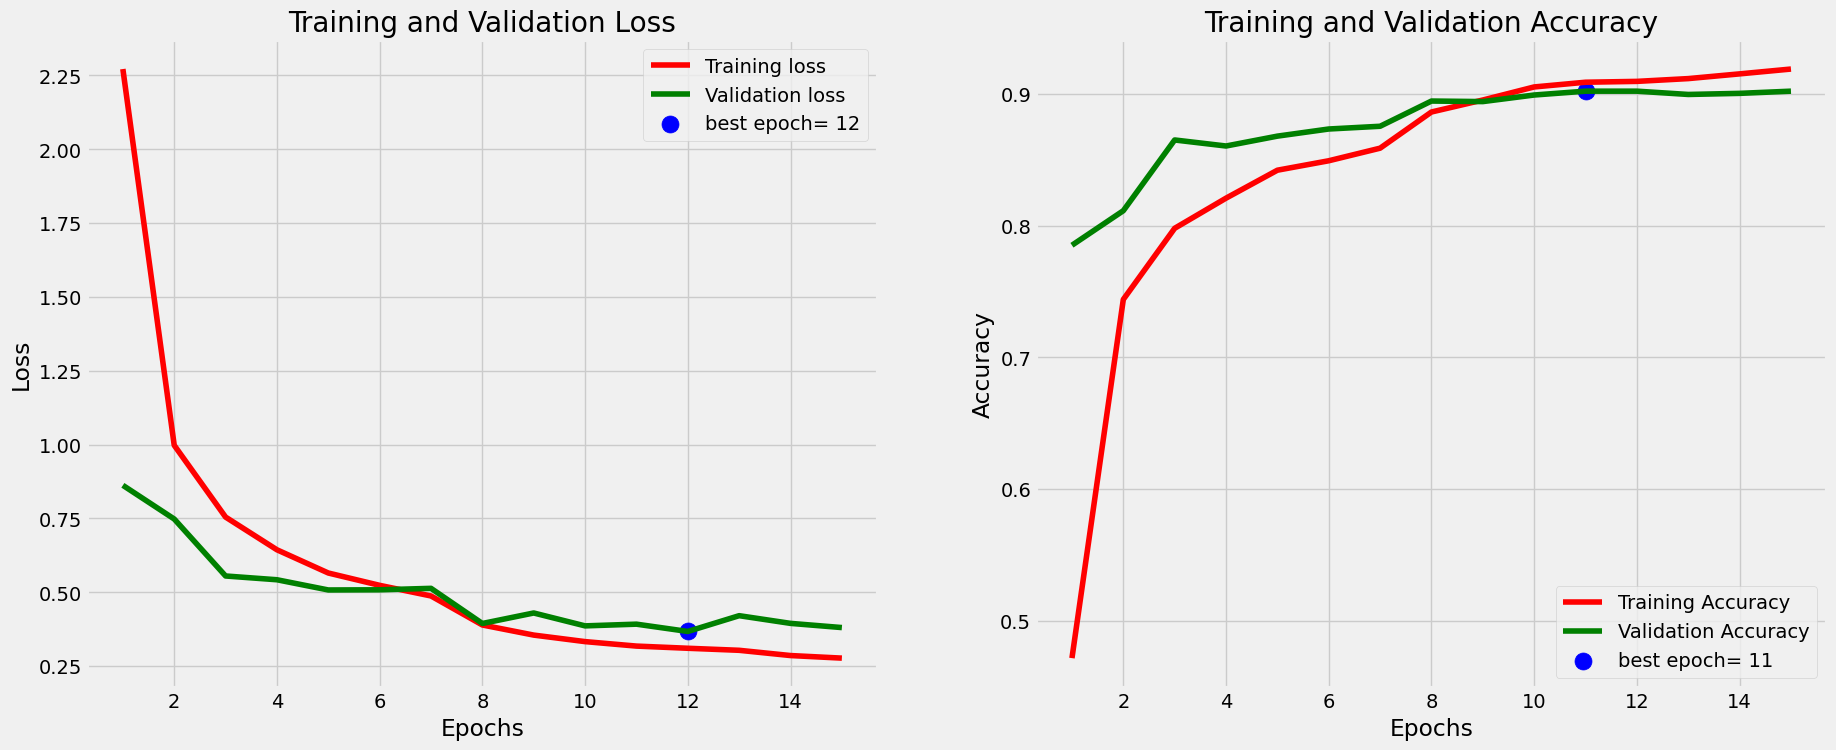

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

model evaluate

In [ ]:
results_mobilenet = model.evaluate(test_images_mobilenet, verbose=0)
print("MobileNet Model - Test Loss: {:.5f}".format(results_mobilenet[0]))
print("MobileNet Model - Test Accuracy: {:.2f}%".format(results_mobilenet[1] * 100))

MobileNet Model - Test Loss: 0.35105
MobileNet Model - Test Accuracy: 90.45%


F1 Score / Recall / Precision


In [ ]:
y_true = test_images_mobilenet.classes
y_pred = np.argmax(model.predict(test_images_mobilenet), axis=1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_mobilenet.class_indices.keys()))

234/234 [==============================] - 12s 47ms/step
F1 Score: 0.9025686360135529
                       precision    recall  f1-score   support

           air hockey       0.83      0.83      0.83        18
      ampute football       0.94      0.94      0.94        18
              archery       0.95      0.90      0.93        21
        arm wrestling       0.73      1.00      0.84        16
         axe throwing       0.94      0.94      0.94        18
         balance beam       1.00      0.92      0.96        24
        barell racing       0.95      1.00      0.98        20
             baseball       0.86      0.89      0.88        28
           basketball       0.92      0.89      0.91        27
       baton twirling       0.94      0.83      0.88        18
            bike polo       0.76      0.89      0.82        18
            billiards       0.95      0.87      0.91        23
                  bmx       0.93      0.59      0.72        22
              bobsled       0.8

#Inception V3

In [ ]:
BATCH_SIZE = 10
IMAGE_SIZE = (299, 299)

generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 10880 validated image filenames belonging to 110 classes.
Found 2401 validated image filenames belonging to 110 classes.
Found 2335 validated image filenames belonging to 110 classes.


In [ ]:
from keras.applications import InceptionV3
# Load the pretrained model
pretrained_model = InceptionV3(
    input_shape=(299, 299, 3),
    include_top=False,  # We don't need the pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Define input shape and create input layer
inputs_inception_v3 = Input(shape=(299, 299, 3), name='inputLayer')
x_inception = augment(inputs_inception_v3)

# Load InceptionV3 Base Model
base_model = InceptionV3(include_top=False, input_tensor=x_inception, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add classification layers on top of InceptionV3
x_inception = base_model.output
x_inception = tf.keras.layers.GlobalAveragePooling2D()(x_inception)
x_inception = Dense(350, activation='relu')(x_inception)
x_inception = BatchNormalization()(x_inception)
x_inception = Dropout(0.25)(x_inception)

# Dynamically set the number of classes based on your dataset
num_classes = len(set(train_images_inception_v3.classes))
x_inception = Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_inception)

# Create the final model
model_inception_v3 = Model(inputs=inputs_inception_v3, outputs=x_inception)

model_inception_v3.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model_inception_v3.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputLayer (InputLayer)     [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 AugmentationLayer (Sequent  (None, 299, 299, 3)          0         ['inputLayer[0][0]']          
 ial)                                                                                             
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['AugmentationLayer[0][0]']   
                                                                                                  
 batch_normalization_96 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']     

Transfer learning

In [ ]:
history_inception_v3 = model_inception_v3.fit(
    train_images_inception_v3,
    steps_per_epoch=len(train_images_inception_v3),
    validation_data=val_images_inception_v3,
    validation_steps=len(val_images_inception_v3),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_inception_v3.save('/content/drive/MyDrive/Thesis /dataset_new/InceptionV3.h5')

Epoch 1/50
1088/1088 [==============================] - 91s 76ms/step - loss: 2.5359 - accuracy: 0.4126 - val_loss: 1.3512 - val_accuracy: 0.6385 - lr: 5.0000e-04
Epoch 2/50
1088/1088 [==============================] - 89s 82ms/step - loss: 1.6072 - accuracy: 0.5989 - val_loss: 1.0590 - val_accuracy: 0.6972 - lr: 5.0000e-04
Epoch 3/50
1088/1088 [==============================] - 82s 75ms/step - loss: 1.3675 - accuracy: 0.6525 - val_loss: 1.0179 - val_accuracy: 0.7005 - lr: 5.0000e-04
Epoch 4/50
1088/1088 [==============================] - 83s 76ms/step - loss: 1.2409 - accuracy: 0.6769 - val_loss: 0.8553 - val_accuracy: 0.7564 - lr: 5.0000e-04
Epoch 5/50
1088/1088 [==============================] - 82s 76ms/step - loss: 1.1513 - accuracy: 0.6893 - val_loss: 0.7746 - val_accuracy: 0.7747 - lr: 5.0000e-04
Epoch 6/50
1088/1088 [==============================] - 80s 74ms/step - loss: 1.1313 - accuracy: 0.6933 - val_loss: 0.7440 - val_accuracy: 0.7768 - lr: 5.0000e-04
Epoch 7/50
1088/1088 [

Display model performance

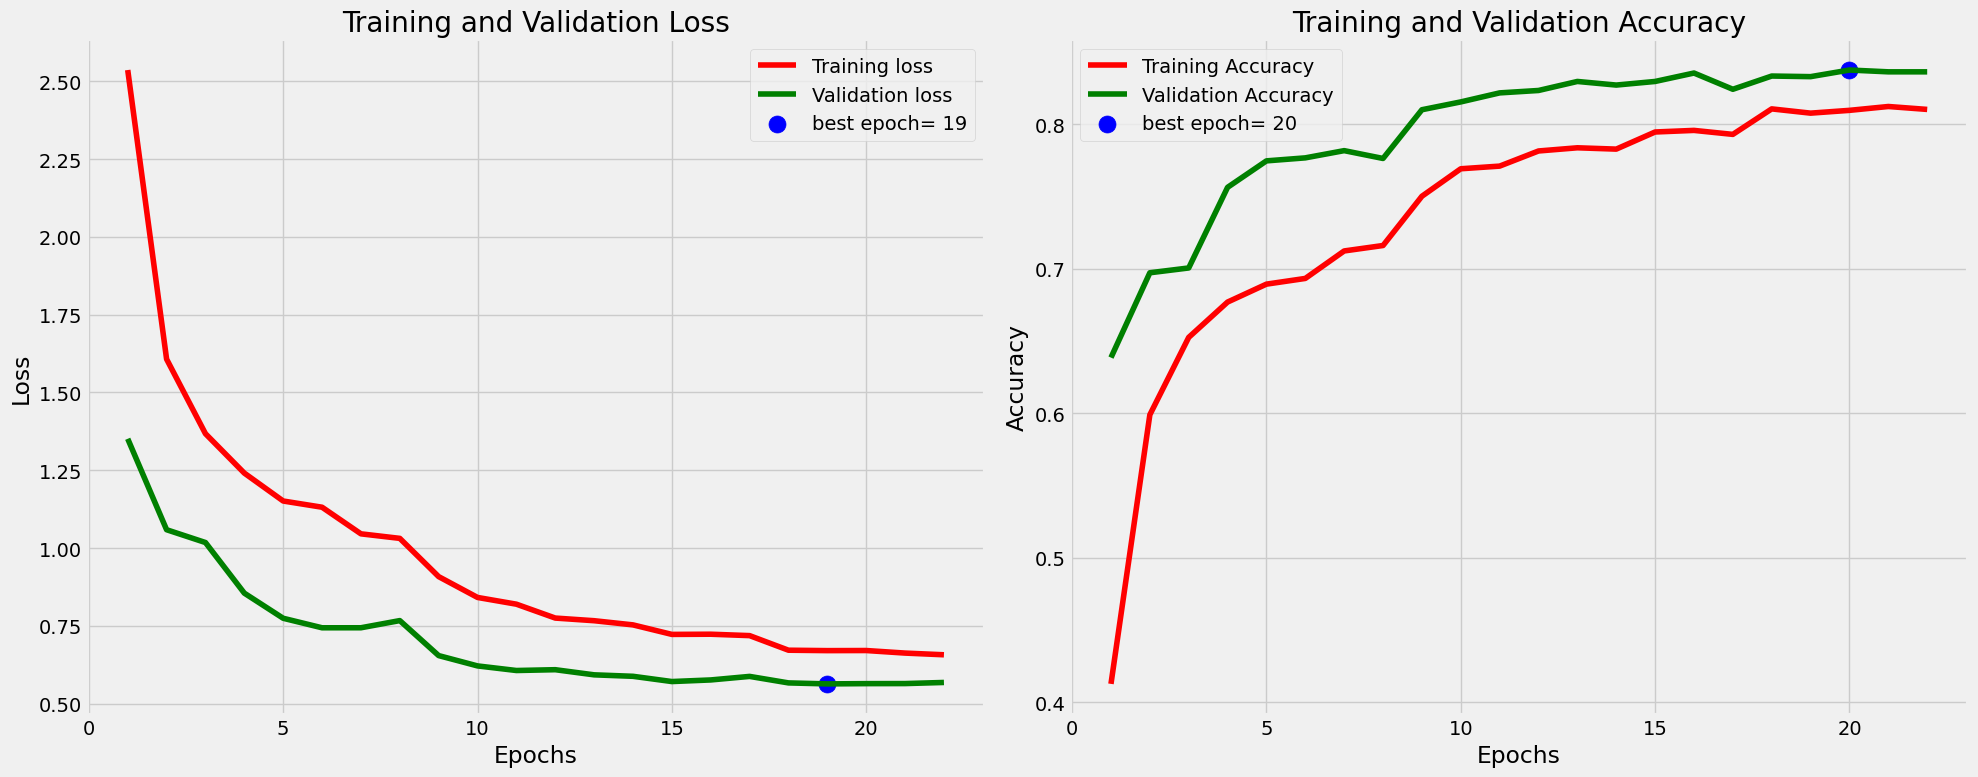

In [ ]:
# Define needed variables
tr_acc = history_inception_v3.history['accuracy']
tr_loss = history_inception_v3.history['loss']
val_acc = history_inception_v3.history['val_accuracy']
val_loss = history_inception_v3.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Model Evaluate

In [ ]:
results = model_inception_v3.evaluate(test_images_inception_v3, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.53045
Test Accuracy: 84.75%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_inception_v3.classes
y_pred = np.argmax(model_inception_v3.predict(test_images_inception_v3), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_inception_v3.class_indices.keys()))

234/234 [==============================] - 15s 58ms/step
F1 Score: 0.8470446553895782
                       precision    recall  f1-score   support

           air hockey       0.89      0.94      0.92        18
      ampute football       0.90      1.00      0.95        18
              archery       0.95      0.90      0.93        21
        arm wrestling       0.80      1.00      0.89        16
         axe throwing       0.94      0.94      0.94        18
         balance beam       0.76      0.92      0.83        24
        barell racing       0.57      1.00      0.73        20
             baseball       0.64      0.82      0.72        28
           basketball       0.65      0.74      0.69        27
       baton twirling       0.55      0.89      0.68        18
            bike polo       0.59      0.94      0.72        18
            billiards       1.00      1.00      1.00        23
                  bmx       0.89      0.77      0.83        22
              bobsled       0.8

#COMPARISON

In [8]:
import pandas as pd

data = {
    'Model': ['ResNet50', 'VGG16', 'MobileNetV3 Large', 'EfficientNetB0', 'InceptionV3'],
    'Accuracy': ["83.73 %", "71.82 %", "90.45 %", "92.03 %", "84.75 %"],
    'F1 Score': [0.83 , 0.71, 0.9, 0.92, 0.84 ]
}

df = pd.DataFrame(data)

# Sort the DataFrame by 'Accuracy' in descending order
df = df.sort_values(by='Accuracy', ascending=False)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the ranked table
print(df)


               Model Accuracy  F1 Score
0     EfficientNetB0  92.03 %      0.92
1  MobileNetV3 Large  90.45 %      0.90
2        InceptionV3  84.75 %      0.84
3           ResNet50  83.73 %      0.83
4              VGG16  71.82 %      0.71


# Best model is EfficientNet B0

Get Predictions

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

234/234 [==============================] - 11s 49ms/step


Image Index  Test Labels     Test Classes  Prediction Labels  \
0            0          109  wingsuit flying                109   
1            1          109  wingsuit flying                109   
2            2          109  wingsuit flying                109   
3            3          109  wingsuit flying                109   
4            4          109  wingsuit flying                109   
5            5          109  wingsuit flying                109   
6            6          109  wingsuit flying                109   
7            7          109  wingsuit flying                109   

  Prediction Classes                                               Path  \
0    wingsuit flying  /content/drive/MyDrive/Thesis /dataset_new/tes...   
1    wingsuit flying  /content/drive/MyDrive/Thesis /dataset_new/tes...   
2    wingsuit flying  /content/drive/MyDrive/Thesis /dataset_new/tes...   
3    wingsuit flying  /content/drive/MyDrive/Thesis /dataset_new/tes...   
4    wingsuit flying  /content/drive/MyDrive/Thesis /dataset_new/tes...   
5    wingsuit flying  /content/drive/MyDrive/Thesis /dataset_new/tes...   
6    wingsuit flying  /content/drive/MyDrive/Thesis /dataset_new/tes...   
7    wingsuit flying  /content/drive/MyDrive/Thesis /dataset_new/tes...   

   Prediction Probability  
0                0.997309  
1                0.885025  
2                0.962628  
3                0.998889  
4                0.917108  
5                0.997681  
6                0.841458  
7                0.987271

Print the most confident errors

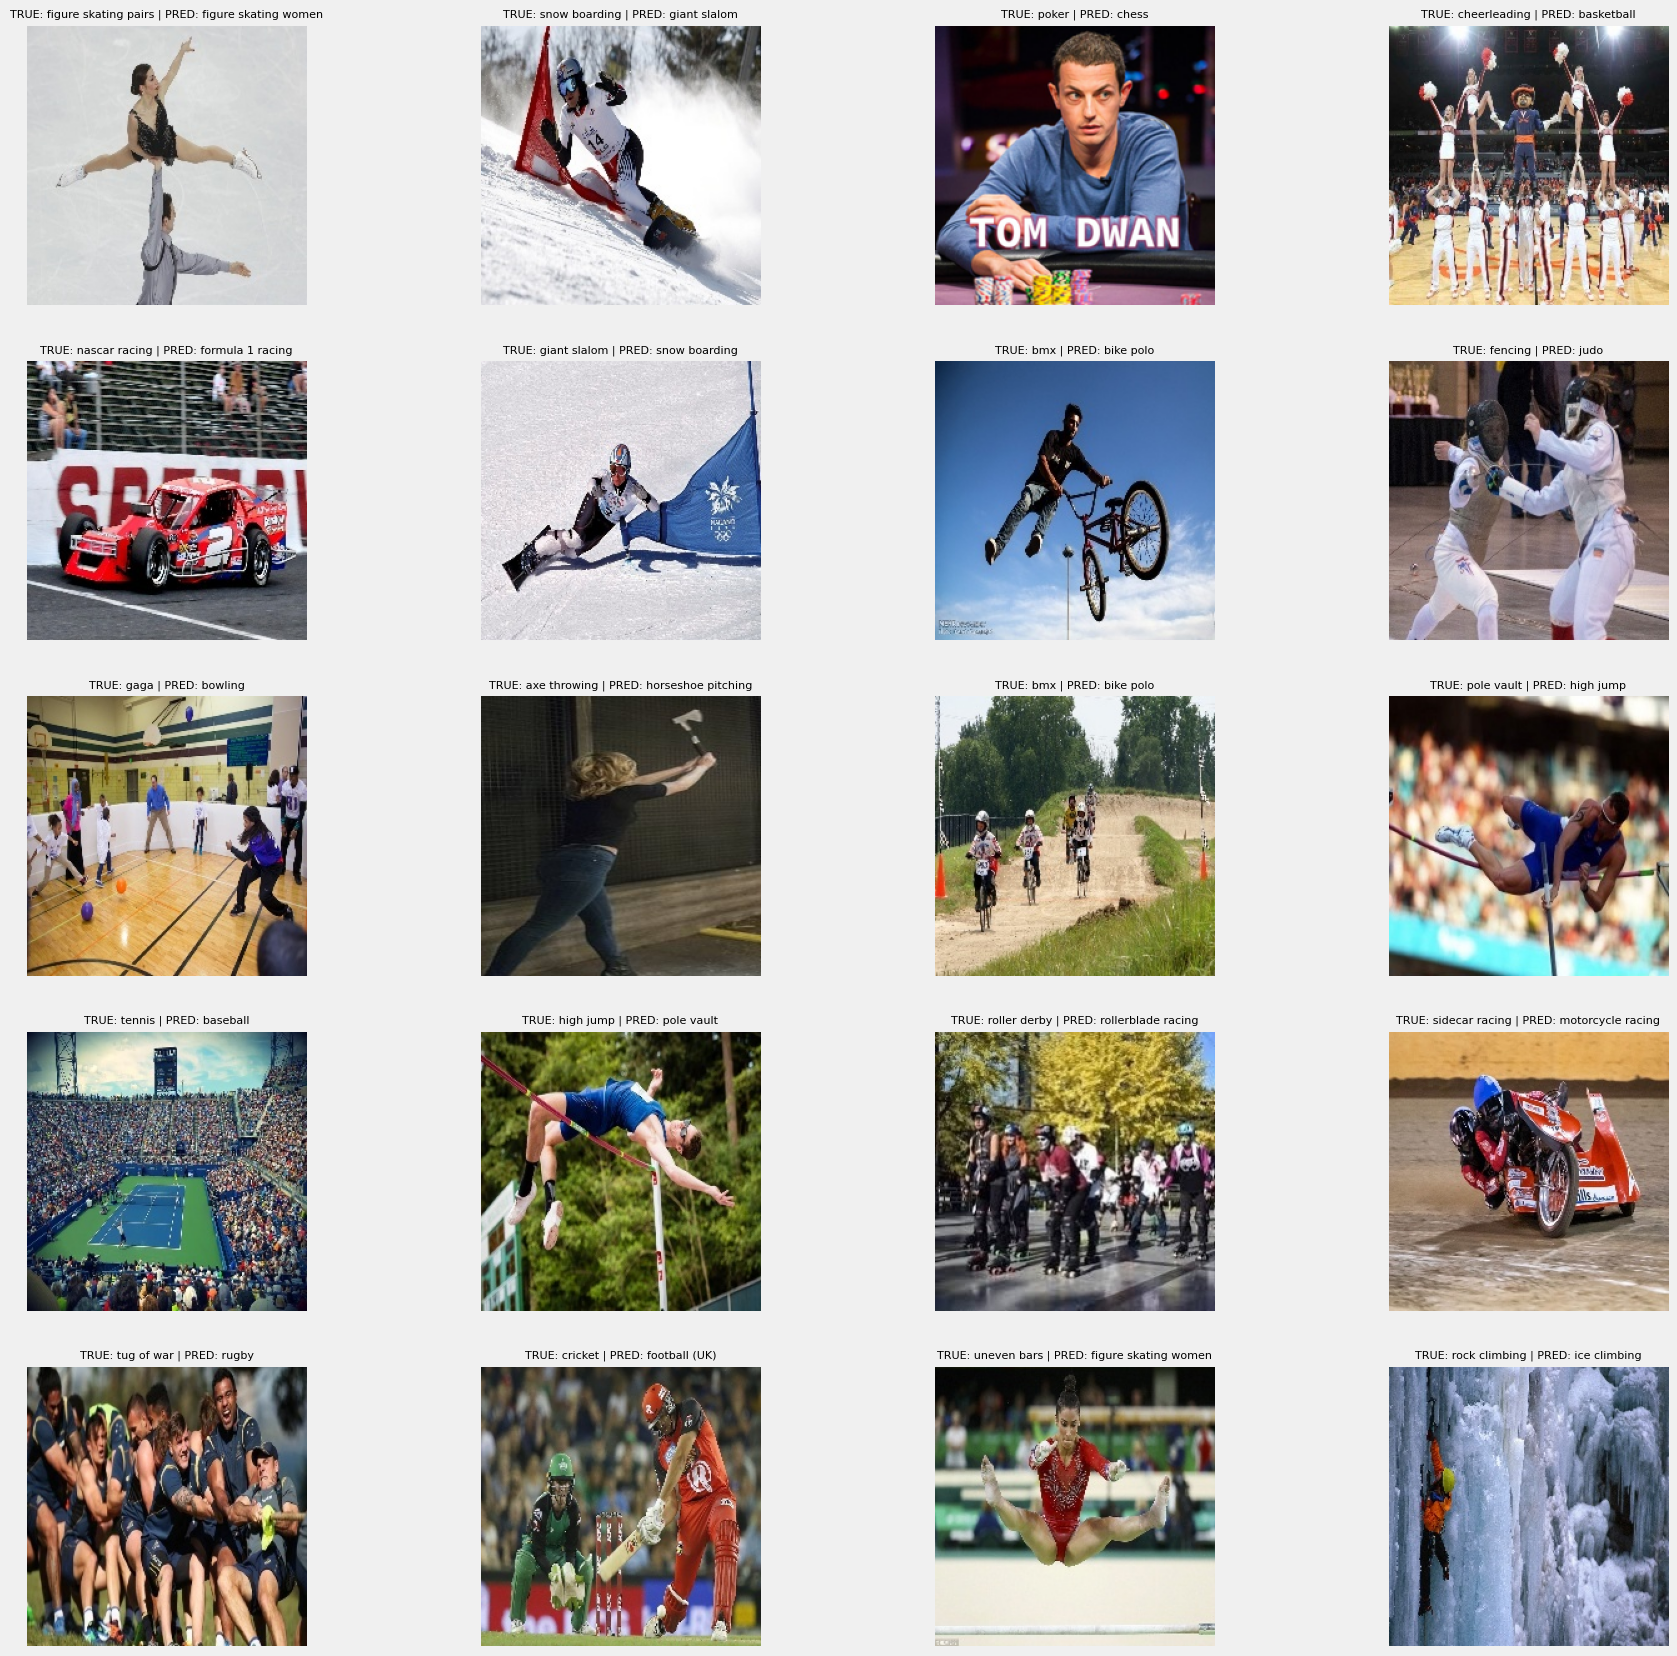

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

Confusion Matrics and Classification Report

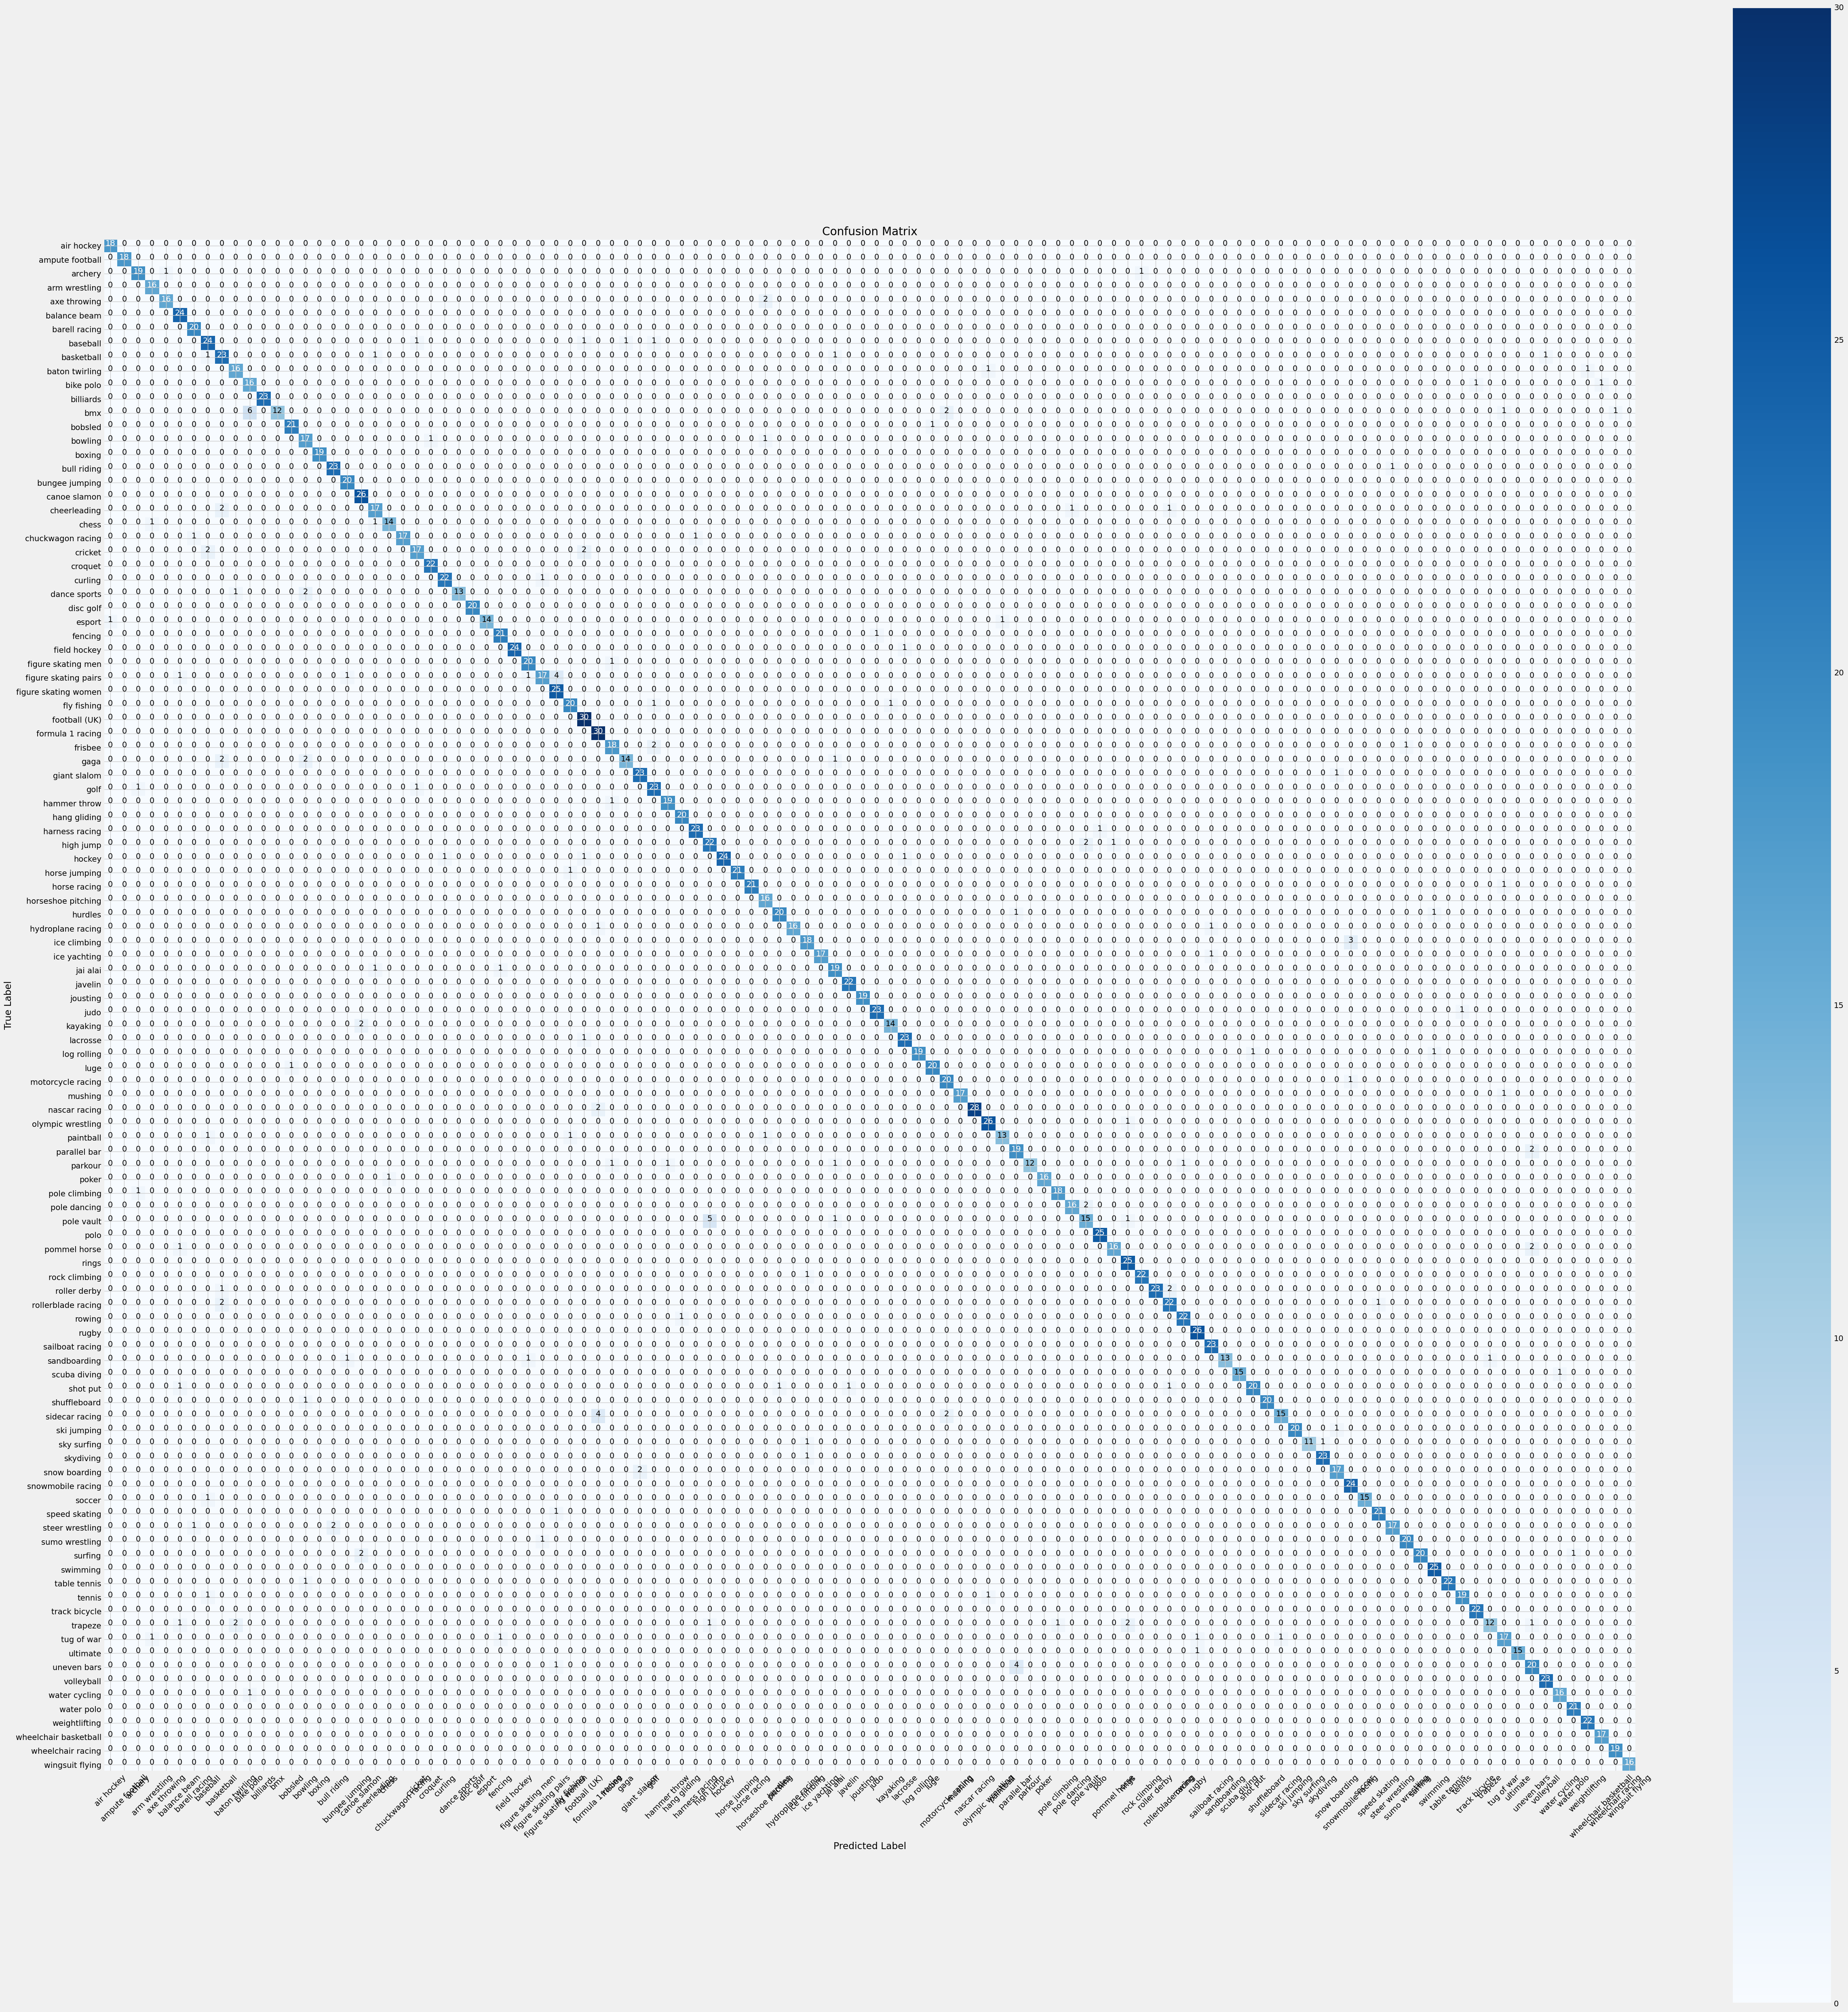

In [ ]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (50, 50))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()